# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.
# Table of Contents
1. [General Information](#step_1)
2. [Analysis](#step_2)
3. [Training & Testing](#step_3)
4. [Conclusion](#step_4)

# General Information<a name='step_1'></a>

Let us import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
random_state=12345

In [10]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

We can now read the data and look through it

In [2]:
data=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
#reads the csv file, makes the datetime column the index, and converts it to datetime type
data.head()#first 5 rows

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()#general info

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


There are no missing values - a welcome sight! Let us check for duplicates by checking how many unique values are present in the datetime index. We have 26496 rows, so if we have 26496 unique index values, then we have no duplicates. Anything less will indicate the presence of duplicates

In [4]:
data.index.unique().shape

(26496,)

We have no duplicates. Let us check whether the index data type is dates

In [5]:
data.index.is_all_dates

True

All our data has the right the data types

# Analysis<a name='step_2'></a>

We will analyze trends and seasonality in different timeframes. First, let us try to plot the number of orders after resampling them by hour.

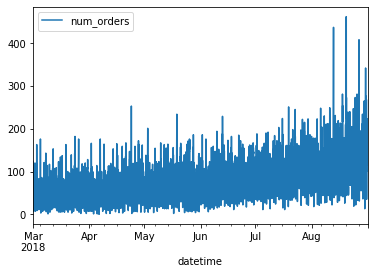

In [6]:
data.sort_index(inplace=True)#sorts the index in ascending order
data_h=data.resample('1H').sum()#resamples the data by the hour
data_h.plot()#makes a plot of our hourly data

That is a lot of data points to look at. So we have to decompose the data into seasonality, trend, and residuals, then plot them 

Text(0.5, 1.0, 'Residuals')

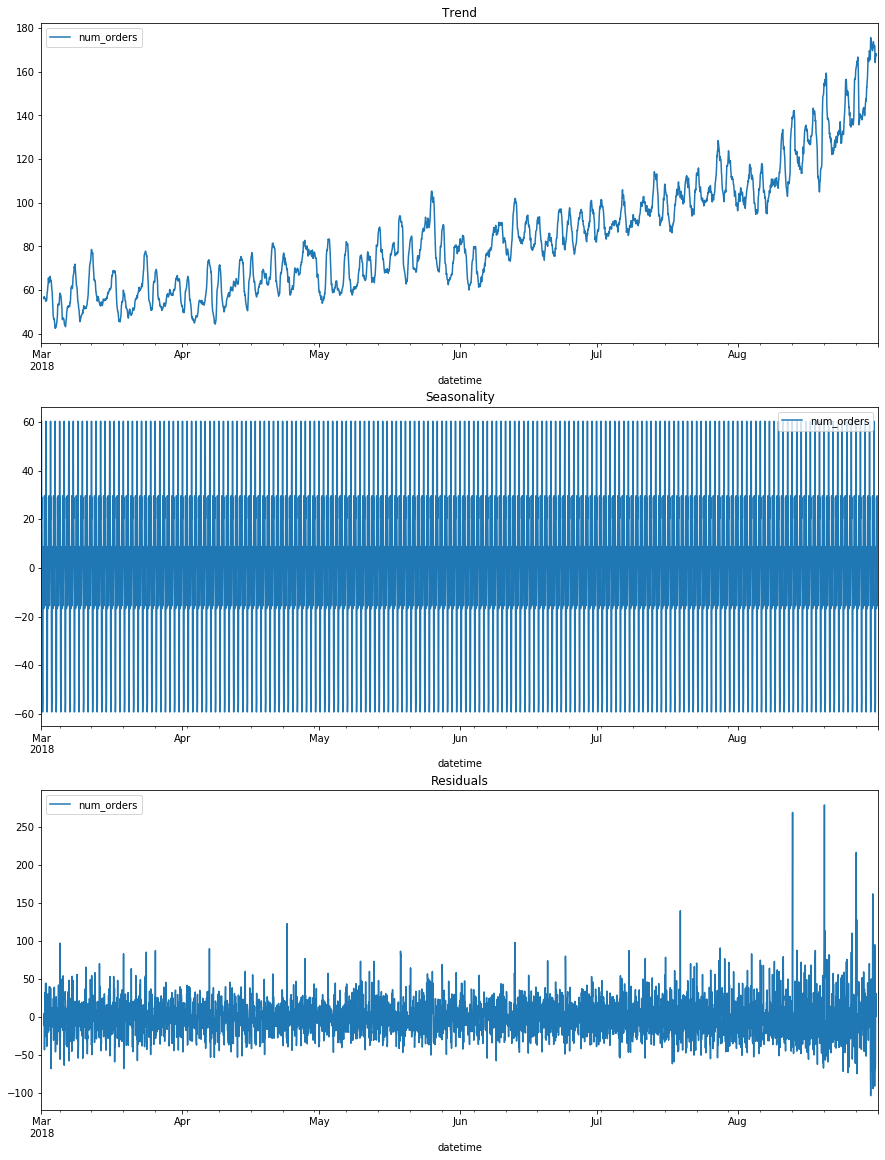

In [7]:
decomposed = seasonal_decompose(data_h)#decomposes the data to trend, seasonality and residuals 

plt.figure(figsize=(15, 20))#creates a figure of height 20in and width 15in

#create the subplots for trend, seasonality, and residuals, gets their axes and fits them in the figure
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

We notice an upward or positive trend throughout the months. We cannot figure out seasonality for that period of time. Residuals tell us when there are unusual spikes or lows. That is still a lot of data points. Let us resample our hourly data to daily data. We will add the rolling mean and rolling standard deviation and plot those points. 

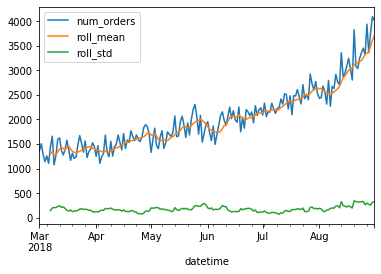

In [8]:
data_day=data_h.resample('1D').sum()#resampling by the day
data_day['roll_mean']=data_day['num_orders'].rolling(7).mean()
#creating a column calculating the rolling mean with a window size of 7
data_day['roll_std']=data_day['num_orders'].rolling(7).std()
#creating a column calculating the rolling standard deviation with a window size of 7
data_day.plot()#plots a graph for the daily data

We observe a steady increase in the mean and a quite steady standard deviation all through. Let's take our hourly data and take 'week' slice and observe the trend and seasonality. We chose April 9 to April 15 (Monday to Sunday)

Text(0.5, 1.0, 'Residuals')

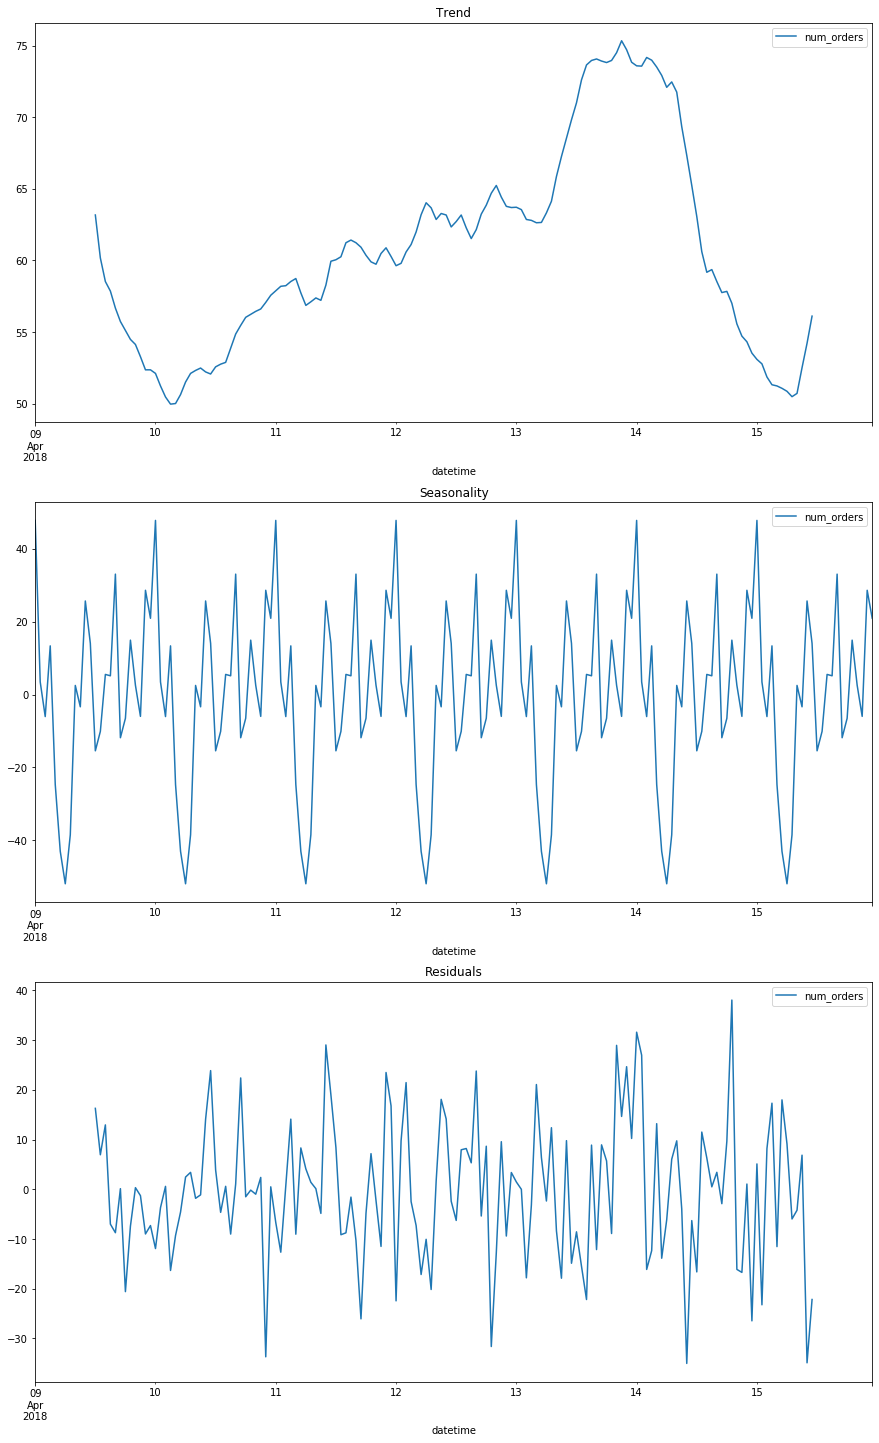

In [9]:
decomposed = seasonal_decompose(data_h.loc['2018-04-09':'2018-04-15',:])#gets the week slice and decomposes it

plt.figure(figsize=(15, 25))#creates a figure with height 25in and width 15in

#create the subplots for trend, seasonality, and residuals, gets their axes and fits them in the figure
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

From the trend, we can see that the highest number of orders came on the 14th (a Saturday). From the seasonality graph, we can see the pattern followed through out the day: A slump from 00:00 to about 06:00, then a rise from then. Many peaks are observed with the highest one at around 11pm. Residuals show spikes in orders, the highest being on Saturday evening. Let us plot with the rolling mean and rolling standard deviation.

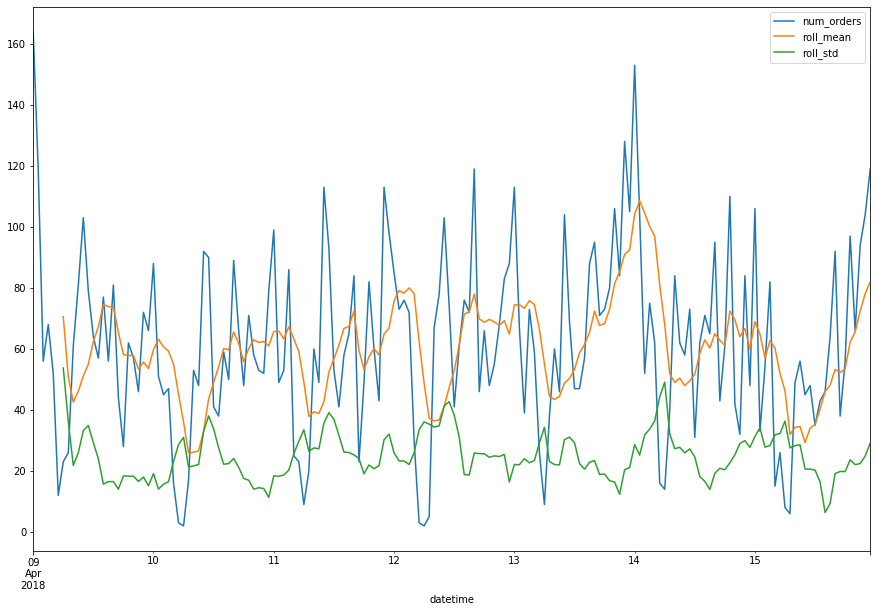

In [11]:
data_spec_w=data_h.loc['2018-04-09':'2018-04-15',:]
data_spec_w['roll_mean']=data_spec_w['num_orders'].rolling(7).mean()
data_spec_w['roll_std']=data_spec_w['num_orders'].rolling(7).std()
data_spec_w.plot(figsize=(15, 10))

Saturday indeed had the highest mean and standard deviation. Let us analyze the trend for 1 day. We took August 30

Text(0.5, 1.0, 'Residuals')

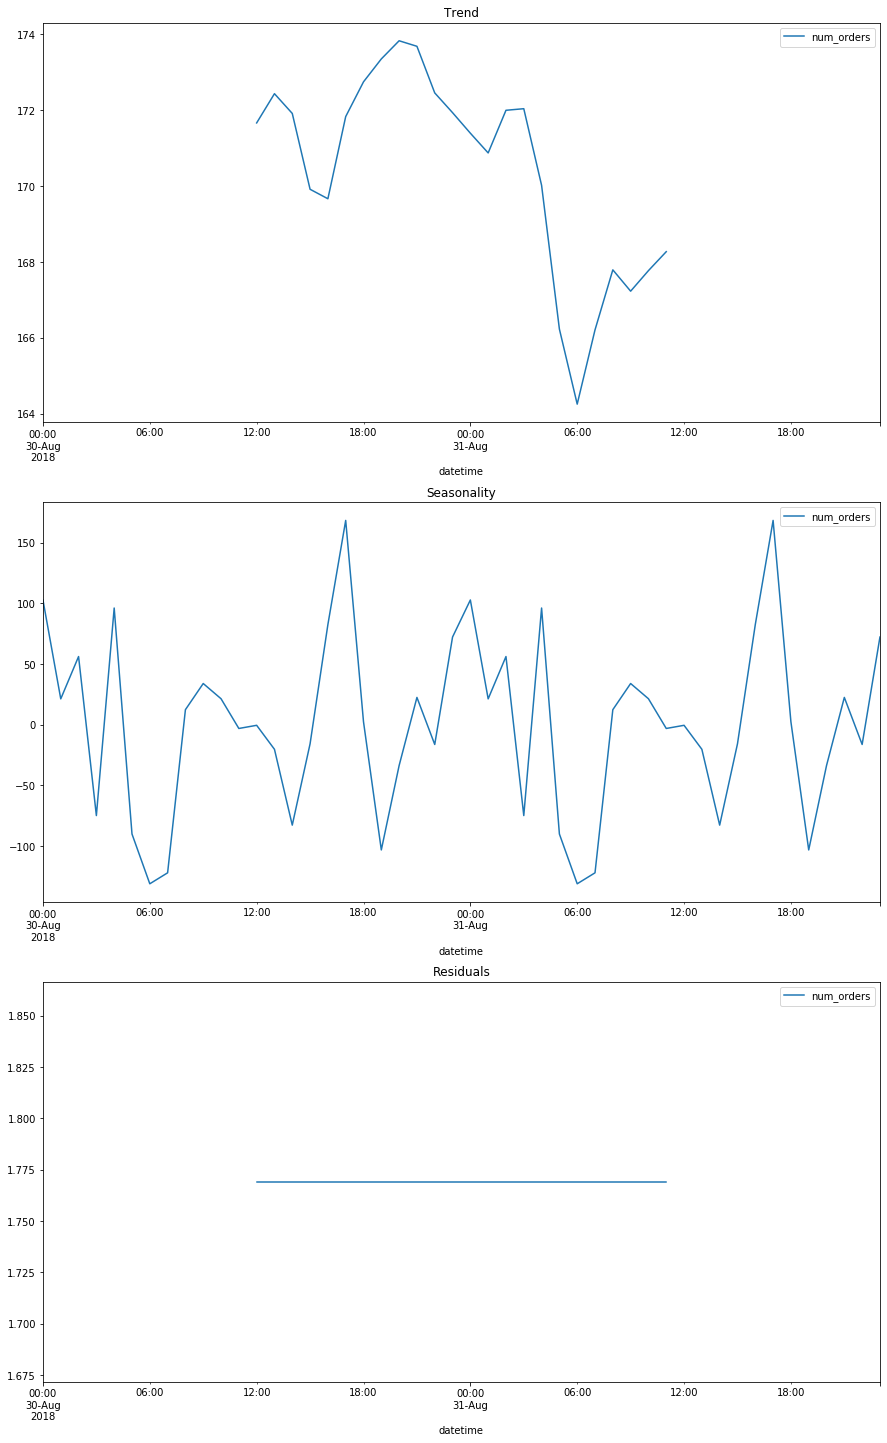

In [12]:
decomposed = seasonal_decompose(data_h.loc['2018-08-30':, :])

plt.figure(figsize=(15, 25))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

The trend and seasonality graphs confirm the pattern we set earlier. There was not enough data for residuals. Let us plot with the rolling mean and rolling standard deviation

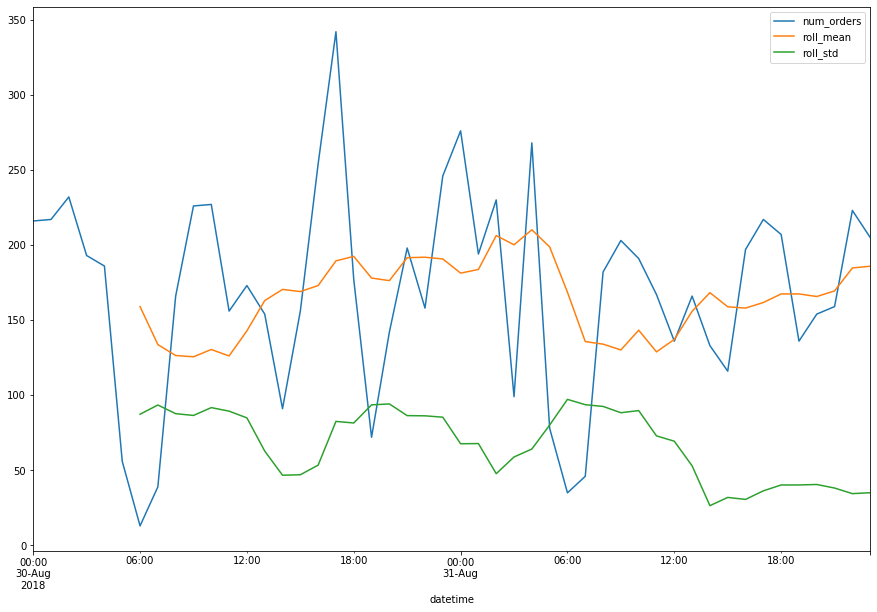

In [13]:
data_spec_d = data_h.loc['2018-08-30':, :].resample('1H').sum()
data_spec_d['roll_mean']=data_spec_d['num_orders'].rolling(7).mean()
data_spec_d['roll_std']=data_spec_d['num_orders'].rolling(7).std()
data_spec_d.plot(figsize=(15, 10))

From the graphs above we can conclude that the day with the most orders is Saturday. The peak hours for taxi orders are between 6pm and 6am

# Training & Testing<a name='step_3'></a>

We need to first of all create calendar features (month, day, dayofweek, hour), rolling mean, and lag features (7 of them) for our target, num_orders.

In [14]:
def make_features(data, max_lag, roll_mean_size):
    #creates a function called make_features which takes the data, max_lag and rolling window size as arguments
    data['month']=data.index.month#creates month column
    data['day']=data.index.day#creates day column
    data['dayofweek']=data.index.dayofweek#creates dayofweek column
    data['hour']=data.index.hour#creates hour column
    
    #creates the lag features for our target
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)]=data['num_orders'].shift(lag)

    data['roll_mean']=data['num_orders'].shift().rolling(roll_mean_size).mean()#creates the rolling mean feature

make_features(data_h, 7, 24)#runs our function on our hourly data, with 7 lag features and a rolling window of 24

data_h.dropna(inplace=True)#drops the missing values
data_h.head()#first 5 rows

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,roll_mean
datetime,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,56.833333
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,55.416667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,56.875000
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,57.041667
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,56.958333


Let us create our features and targets

In [15]:
f=data_h.drop(['num_orders'], axis=1)#features
t=data_h['num_orders']#targets

Let us split the data. We need to prevent shuffling by setting 'shuffle=False' and not putting any random_state since we are predicting according to the progression of time

In [16]:
f_train, f_test, t_train, t_test=train_test_split(f, t, shuffle=False, test_size=0.1)
#splits the data, preventing shuffling

#print shapes of splits
print(f_train.shape)
print(t_train.shape)
print(f_test.shape)
print(t_test.shape)

(3952, 12)
(3952,)
(440, 12)
(440,)


We will create a separate set which will have one-hot encoding for the month, day, dayofweek, and hour features. We will not use this data for the tree models

In [17]:
data_h_ohe=pd.get_dummies(data=data_h, columns=['month', 'day', 'dayofweek', 'hour'], drop_first=True)
#gets dummy columns for the 'month', 'day', 'dayofweek', 'hour' columns

f_ohe=data_h_ohe.drop(['num_orders'], axis=1)
t_ohe=data_h_ohe['num_orders']
f_train_ohe, f_test_ohe, t_train_ohe, t_test_ohe=train_test_split(f_ohe, t_ohe, shuffle=False, test_size=0.1)
print(f_train_ohe.shape)
print(t_train_ohe.shape)
print(f_test_ohe.shape)
print(t_test_ohe.shape)

(3952, 72)
(3952,)
(440, 72)
(440,)


Let us create our RMSE function.

In [18]:
def rmse(targ, pred):
    pred=np.array(pred)#makes the predictions into an array
    targ=np.array(targ)#makes the target into an array
    error=pred-targ#gets the error array
    sq_error=error**2#squares the values
    msq_error=sq_error.mean()#gets the mean
    score=msq_error**0.5#gets the square root of the mean
    return score
scorer=make_scorer(rmse, greater_is_better=False)#makes our function an evaluation metric, lower values are better

## Linear Regression

We will do some cross-validation

In [19]:
#LR cross-validation
lr=LinearRegression()
lr_score=cross_val_score(lr, f_train, t_train, scoring=scorer, cv=3)
print(lr_score.mean())

-30.803849777548265


Now we can train, test, and get the RMSE

In [20]:
lr=LinearRegression()
lr.fit(f_train, t_train)
lr_pred=lr.predict(f_test)
lr_rmse=rmse(t_test, lr_pred)
lr_rmse

51.31242058840531

Let us repeat the above process with the encoded sets

In [21]:
lr_ohe=LinearRegression()
lr_ohe.fit(f_train_ohe, t_train_ohe)
lr_ohe_pred=lr_ohe.predict(f_test_ohe)
lr_ohe_rmse=rmse(t_test_ohe, lr_ohe_pred)
lr_ohe_rmse

45.33827575859241

The encoding improved Linear Regression Model quality

## Decision Tree

We will perform hyperparameter tuning (with max_depth hyperparameter) and get cross_validation scores. We will train the model with the hyperparameter which yields the best score

In [22]:
#DTR hyperparameter tuning with max depth to get cross_validation scores
for depth in range(1, 10):
    dtr=DecisionTreeRegressor(max_depth=depth, random_state=random_state)
    dtr_score=cross_val_score(dtr, f_train, t_train, scoring=scorer, cv=3)
    print('Max depth=', depth, ':', dtr_score.mean())

Max depth= 1 : -36.939625098103456
Max depth= 2 : -35.5945580529301
Max depth= 3 : -32.833954741934114
Max depth= 4 : -31.134752835448367
Max depth= 5 : -31.04995476262515
Max depth= 6 : -30.8222110779537
Max depth= 7 : -30.189436656929598
Max depth= 8 : -30.875845035145158
Max depth= 9 : -31.54169537149693


Now we can train and test, then get the RMSE

In [23]:
dtr=DecisionTreeRegressor(max_depth=7, random_state=random_state)
dtr.fit(f_train, t_train)
dtr_pred=dtr.predict(f_test)
dtr_rmse=rmse(t_test, dtr_pred)
dtr_rmse

56.52130613499048

It performed worse than our baseline Linear Regression Model

## Random Forest

We performed hyperparameter tuning with max_depth and n_estimators and our best cross-validation score was gotten by n_estimators=40, max_depth=10

In [24]:
#Random Forest Regression hyperparameter tuning to get cross_validation scores
for depth in range(1, 11):
    rfr=RandomForestRegressor(n_estimators=40, max_depth=depth, random_state=random_state)
    rfr_score=cross_val_score(rfr, f_train, t_train, scoring=scorer, cv=3)
    print('Max depth=', depth, ':', rfr_score.mean())

Max depth= 1 : -36.556179279540096
Max depth= 2 : -34.58258358299548
Max depth= 3 : -31.847614013399156
Max depth= 4 : -29.946342258584934
Max depth= 5 : -28.747175811169466
Max depth= 6 : -28.06688961370705
Max depth= 7 : -27.3563905843413
Max depth= 8 : -26.864976802540184
Max depth= 9 : -26.485259678406106
Max depth= 10 : -26.30383320619445


We can now train and test, then get the RMSE with these parameters

In [25]:
rfr=RandomForestRegressor(n_estimators=40, max_depth=10, random_state=random_state)
rfr.fit(f_train, t_train)
rfr_pred=rfr.predict(f_test)
rfr_rmse=rmse(t_test, dtr_pred)
rfr_rmse

56.52130613499048

## CatBoost Regressor

We will first do hyperparameter tuning with GridSearchCV to get the best parameters to train the model

In [26]:
#CB
model=CatBoostRegressor()
parameters={'depth':[6, 8, 10],
            'learning_rate':[0.5, 0.1],
            'l2_leaf_reg':[2, 4],
            'iterations':[10, 50],
            'loss_function':['RMSE'],
            'random_seed':[random_state]}#parameters to search
grid=GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=3, n_jobs=-1, verbose=0)
#Hyperparameter tuning
grid.fit(f_train, t_train)#fits the training data
best_param=grid.best_params_#gets the best parameters

0:	learn: 31.1951016	total: 53.4ms	remaining: 480ms
1:	learn: 28.2357161	total: 59.1ms	remaining: 237ms
2:	learn: 26.4744950	total: 115ms	remaining: 267ms
3:	learn: 25.1553208	total: 120ms	remaining: 180ms
4:	learn: 24.4343578	total: 125ms	remaining: 125ms
5:	learn: 24.2798861	total: 130ms	remaining: 86.7ms
6:	learn: 23.8330314	total: 215ms	remaining: 92.3ms
7:	learn: 23.5971688	total: 220ms	remaining: 55.1ms
8:	learn: 23.3685316	total: 227ms	remaining: 25.2ms
9:	learn: 23.2963101	total: 232ms	remaining: 0us
0:	learn: 31.0578524	total: 8.81ms	remaining: 79.3ms
1:	learn: 27.2659762	total: 16.9ms	remaining: 67.5ms
2:	learn: 25.6980404	total: 97ms	remaining: 226ms
3:	learn: 24.0774515	total: 105ms	remaining: 157ms
4:	learn: 23.4255857	total: 112ms	remaining: 112ms
5:	learn: 23.1878319	total: 192ms	remaining: 128ms
6:	learn: 22.9778804	total: 201ms	remaining: 86ms
7:	learn: 22.7337797	total: 208ms	remaining: 51.9ms
8:	learn: 22.3745175	total: 291ms	remaining: 32.3ms
9:	learn: 21.6404475	to

Let us print out the best parameters:

In [27]:
print('Best score from searched params:', grid.best_score_)
print('Best parameters:', best_param)

Best score from searched params: -26.09399490921668
Best parameters: {'depth': 8, 'iterations': 50, 'l2_leaf_reg': 2, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'random_seed': 12345}


Now we can train, test, and get the RMSE with those hyperparameters

In [28]:
cbr=CatBoostRegressor(iterations=best_param['iterations'],
                      depth=best_param['depth'],
                      learning_rate=best_param['learning_rate'],
                      l2_leaf_reg=best_param['l2_leaf_reg'],
                      loss_function='RMSE',
                      random_seed=random_state)
cbr.fit(f_train, t_train, verbose=False, plot=False)
cbr_pred=cbr.predict(f_test)
cbr_rmse=rmse(t_test, cbr_pred)
cbr_rmse

49.61631939150038

Let's do the same thing, but this time we will use the OHE data

In [29]:
#CB_OHE
model=CatBoostRegressor()
parameters={'depth':[6, 8, 10],
            'learning_rate':[0.5, 0.1],
            'l2_leaf_reg':[2, 4],
            'iterations':[10, 50],
            'loss_function':['RMSE'],
            'random_seed':[random_state]}
grid=GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=3, n_jobs=-1, verbose=0)
grid.fit(f_train_ohe, t_train_ohe)
best_param=grid.best_params_

0:	learn: 33.7750430	total: 5.35ms	remaining: 48.2ms
1:	learn: 30.3126025	total: 10.9ms	remaining: 43.5ms
2:	learn: 28.7835554	total: 15.8ms	remaining: 36.8ms
3:	learn: 27.6081185	total: 84.2ms	remaining: 126ms
4:	learn: 26.8349584	total: 89.5ms	remaining: 89.5ms
5:	learn: 26.2222468	total: 93.7ms	remaining: 62.5ms
6:	learn: 26.0614244	total: 182ms	remaining: 78ms
7:	learn: 25.8392744	total: 187ms	remaining: 46.8ms
8:	learn: 25.5497403	total: 191ms	remaining: 21.2ms
9:	learn: 25.3021187	total: 280ms	remaining: 0us
0:	learn: 34.1077930	total: 6.47ms	remaining: 58.2ms
1:	learn: 30.3060881	total: 12.7ms	remaining: 50.7ms
2:	learn: 28.6636585	total: 54.5ms	remaining: 127ms
3:	learn: 27.4778808	total: 57.3ms	remaining: 85.9ms
4:	learn: 26.4692951	total: 61.1ms	remaining: 61.1ms
5:	learn: 25.8872242	total: 66ms	remaining: 44ms
6:	learn: 25.3972983	total: 154ms	remaining: 66ms
7:	learn: 25.1963295	total: 160ms	remaining: 40ms
8:	learn: 25.0363398	total: 167ms	remaining: 18.5ms
9:	learn: 24.60

In [30]:
print('Best score from searched params:', grid.best_score_)
print('Best parameters:', best_param)

Best score from searched params: -28.24102412581068
Best parameters: {'depth': 6, 'iterations': 50, 'l2_leaf_reg': 2, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'random_seed': 12345}


The cross-validation function will always negate the value of a metric that should be minimized. The score that is returned is therefore negated when it is a score that should be minimized and left positive if it is a score that should be maximized. When making it our scorer, we set 'greater_is_better=False', because we are looking to minimize it

In [31]:
#training, predictions and RMSE
cbr_ohe=CatBoostRegressor(iterations=best_param['iterations'],
                      depth=best_param['depth'],
                      learning_rate=best_param['learning_rate'],
                      l2_leaf_reg=best_param['l2_leaf_reg'],
                      loss_function='RMSE',
                      random_seed=random_state)
cbr.fit(f_train_ohe, t_train_ohe, verbose=False, plot=False)
cbr_ohe_pred=cbr.predict(f_test_ohe)
cbr_ohe_rmse=rmse(t_test_ohe, cbr_ohe_pred)
cbr_ohe_rmse

47.36840313612238

## Light GBM

Like above, we perform hyperparameter tuning:

In [32]:
#LGBM
model=LGBMRegressor()
parameters={'num_leaves':[10, 20, 30],
            'learning_rate':[0.5, 0.1],
            'n_estimators':[10, 20],
            'objective':['rmse'],
            'random_state':[random_state]}
grid=GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=3, n_jobs=-1, verbose=0)
grid.fit(f_train, t_train)
best_param=grid.best_params_

In [33]:
print('Best score from searched params:', grid.best_score_)
print('Best parameters:', best_param)

Best score from searched params: -25.511466471718535
Best parameters: {'learning_rate': 0.5, 'n_estimators': 10, 'num_leaves': 30, 'objective': 'rmse', 'random_state': 12345}


Then, we train, test and get the RMSE

In [34]:
#train, test, get RMSE
lgbm=LGBMRegressor(num_leaves=best_param['num_leaves'],
                      learning_rate=best_param['learning_rate'],
                      n_estimators=best_param['n_estimators'],
                      objective='rmse',
                      random_state=random_state)
lgbm.fit(f_train, t_train)
lgbm_pred=lgbm.predict(f_test)
lgbm_rmse=rmse(t_test, lgbm_pred)
lgbm_rmse

44.412265827226854

We repeat the data with encoded data

In [35]:
#LGBM_OHE
model=LGBMRegressor()
parameters={'num_leaves':[10, 20, 30],
            'learning_rate':[0.5, 0.1],
            'n_estimators':[10, 20],
            'objective':['rmse'],
            'random_state':[random_state]}
grid=GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=3, n_jobs=-1, verbose=0)
grid.fit(f_train_ohe, t_train_ohe)
best_param=grid.best_params_

In [36]:
print('Best score from searched params:', grid.best_score_)
print('Best parameters:', best_param)

Best score from searched params: -28.155145404832034
Best parameters: {'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 10, 'objective': 'rmse', 'random_state': 12345}


In [37]:
lgbm_ohe=LGBMRegressor(num_leaves=best_param['num_leaves'],
                      learning_rate=best_param['learning_rate'],
                      n_estimators=best_param['n_estimators'],
                      objective='rmse',
                      random_state=random_state)
lgbm_ohe.fit(f_train_ohe, t_train_ohe)
lgbm_ohe_pred=lgbm_ohe.predict(f_test_ohe)
lgbm_ohe_rmse=rmse(t_test_ohe, lgbm_ohe_pred)
lgbm_ohe_rmse

45.667082220000744

# Conclusion<a name='step_4'></a>

We analyzed the Time series data and saw that the peak day for taxi trips was Satuday and the peak hours were between 6pm and 6am

In [38]:
summary=pd.DataFrame(index=['LR', 'LR_ohe', 'DTR', 'RFR', 'CBR', 'CBR_ohe', 'LGBM', 'LGBM_ohe'],
                     data={'RMSE':[lr_rmse, lr_ohe_rmse, dtr_rmse, rfr_rmse, cbr_rmse, cbr_ohe_rmse,
                                   lgbm_rmse, lgbm_ohe_rmse]})
summary

,RMSE
LR,51.312421
LR_ohe,45.338276
DTR,56.521306
RFR,56.521306
CBR,49.616319
CBR_ohe,47.368403
LGBM,44.412266
LGBM_ohe,45.667082


From the table above, we see that the LGBM model has the best root mean squared error. So that will be our recommendation 